In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from stack_segmentation.stack import Stack

In [5]:
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from stack_segmentation.pipeline_config import (
    dataloaders_conf,
    train_conf,
    model_config, 
    aug_config,
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [6]:
from exp_config import data_conf

## Parameters to tune

In [7]:
train_conf['device'] = 'cuda:1'
# train_conf['device'] = 'cpu'
train_conf['num_epochs'] = 300
train_conf

{'num_epochs': 300, 'device': 'cuda:1'}

In [8]:
data_conf['conf_name'] = 'basic_lr1e-2_epoch300_resnet50_encoder'
data_conf

{'conf_name': 'basic_lr1e-2_epoch300_resnet50_encoder',
 'stacks': [{'path': '../../data/carb96558',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(250, 470, None))},
  {'path': '../../data/SoilB-2',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 230, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(240, 460, None))},
  {'path': '../../data/Urna_22',
   'slice_train': (slice(None, None, None),
    slice(None, None, None),
    slice(None, 220, None)),
   'slice_val': (slice(None, None, None),
    slice(None, None, None),
    slice(245, 455, None))},
  {'path': '../../data/carb96558',
   'slice_test': (slice(None, None, None),
    slice(None, None, None),
    slice(490, None, None))},
  {'path': '../../data/carb71',
   'slice_test': (slice(None, None, None),
    slice(None,

In [9]:
model_config

{'source': 'qubvel',
 'model_type': 'Unet',
 'encoder_name': 'resnet50',
 'encoder_weights': 'imagenet'}

In [10]:
optimizer_config['opt_type'] = 'SGD'
optimizer_config['lr'] = 1e-2
optimizer_config['nesterov'] = True
optimizer_config

{'opt_type': 'SGD',
 'lr': 0.01,
 'weight_decay': 0.0001,
 'amsgrad': False,
 'nesterov': True,
 'momentum': 0.9,
 'centered': False}

In [11]:
loss_config =[
    {'loss': 'BCE', 'weight': 1, 'params': {}},
]
loss_config

[{'loss': 'BCE', 'weight': 1, 'params': {}}]

In [12]:
data_conf['patches']

{'train': (128, 128, 1), 'val': (128, 128, 1), 'test': (128, 128, 1)}

## Prepare train, validation and test data

In [13]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 683.01it/s]
100%|██████████| 720/720 [00:07<00:00, 93.66it/s] 
8280it [00:00, 247967.48it/s]
7920it [00:00, 248256.00it/s]
700it [00:00, 803.64it/s]
100%|██████████| 700/700 [00:07<00:00, 99.90it/s] 
8280it [00:00, 251822.47it/s]
7920it [00:00, 243367.16it/s]
710it [00:00, 777.41it/s]
100%|██████████| 710/710 [00:07<00:00, 96.34it/s] 
7920it [00:00, 83709.78it/s]
7560it [00:00, 237557.51it/s]
720it [00:00, 786.71it/s]
100%|██████████| 720/720 [00:07<00:00, 92.16it/s] 
8280it [00:00, 254468.46it/s]
720it [00:00, 805.20it/s]
100%|██████████| 720/720 [00:07<00:00, 95.16it/s] 
25920it [00:00, 136302.31it/s]
700it [00:00, 797.51it/s]
100%|██████████| 700/700 [00:07<00:00, 97.26it/s] 
25200it [00:00, 124802.18it/s]
509it [00:00, 1138.22it/s]
100%|██████████| 509/509 [00:02<00:00, 193.54it/s]
8144it [00:00, 229074.28it/s]
700it [00:00, 803.90it/s]
100%|██████████| 700/700 [00:07<00:00, 97.78it/s] 
25200it [00:00, 233644.78it/s]
700it [00:00, 809.78it/s]
100%|██████████| 700/700 

In [14]:
len(data_train), len(data_val), len(data_test)

(24480, 23400, 11)

In [15]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=None,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [16]:
device = 'cuda:1'
# device = 'cpu'

In [17]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [18]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [19]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [20]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 0...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.045783


100%|██████████| 732/732 [00:31<00:00, 23.41it/s]


Mean val loss: 0.021577


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 1...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01936


100%|██████████| 732/732 [00:30<00:00, 23.78it/s]


Mean val loss: 0.017124


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 2...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.017026


100%|██████████| 732/732 [00:31<00:00, 23.56it/s]


Mean val loss: 0.015843


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 3...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.015985


100%|██████████| 732/732 [00:31<00:00, 23.23it/s]


Mean val loss: 0.015081


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 4...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01527


100%|██████████| 732/732 [00:30<00:00, 23.87it/s]


Mean val loss: 0.014944


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 5...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01481


100%|██████████| 732/732 [00:31<00:00, 23.50it/s]


Mean val loss: 0.014447


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 6...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014493


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.014818
EarlyStopping counter: 1 out of 10
Epoch 7...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.014234


100%|██████████| 732/732 [00:31<00:00, 23.55it/s]


Mean val loss: 0.013941


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 8...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013886


100%|██████████| 732/732 [00:30<00:00, 23.68it/s]


Mean val loss: 0.01372


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 9...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013793


100%|██████████| 732/732 [00:31<00:00, 23.34it/s]


Mean val loss: 0.013666


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 10...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013539


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013719
EarlyStopping counter: 1 out of 10
Epoch 11...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013422


100%|██████████| 732/732 [00:31<00:00, 23.31it/s]


Mean val loss: 0.013339


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 12...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013228


100%|██████████| 732/732 [00:31<00:00, 23.46it/s]


Mean val loss: 0.013342


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 13...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01318


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013361
EarlyStopping counter: 1 out of 10
Epoch 14...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.013035


100%|██████████| 732/732 [00:31<00:00, 22.94it/s]


Mean val loss: 0.013193


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 15...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012954


100%|██████████| 732/732 [00:31<00:00, 23.39it/s]


Mean val loss: 0.013097


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 16...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01281


100%|██████████| 732/732 [00:31<00:00, 23.00it/s]


Mean val loss: 0.012953


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 17...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012702


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013076
EarlyStopping counter: 1 out of 10
Epoch 18...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012622


100%|██████████| 732/732 [00:31<00:00, 23.45it/s]


Mean val loss: 0.012907


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 19...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012581


100%|██████████| 732/732 [00:31<00:00, 23.53it/s]


Mean val loss: 0.012797


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 20...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012519


100%|██████████| 732/732 [00:31<00:00, 23.46it/s]


Mean val loss: 0.012729


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 21...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012402


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012794
EarlyStopping counter: 1 out of 10
Epoch 22...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012379


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013767
EarlyStopping counter: 2 out of 10
Epoch 23...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012308


100%|██████████| 732/732 [00:30<00:00, 23.76it/s]


Mean val loss: 0.012697


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 24...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012238


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012791
EarlyStopping counter: 1 out of 10
Epoch 25...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012197


100%|██████████| 732/732 [00:31<00:00, 23.50it/s]


Mean val loss: 0.012516


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 26...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012154


100%|██████████| 732/732 [00:31<00:00, 23.50it/s]


Mean val loss: 0.012498


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 27...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012141


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012761
EarlyStopping counter: 1 out of 10
Epoch 28...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012064


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012775
EarlyStopping counter: 2 out of 10
Epoch 29...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012055


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012563
EarlyStopping counter: 3 out of 10
Epoch 30...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.012023


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012656
EarlyStopping counter: 4 out of 10
Epoch 31...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011927


100%|██████████| 732/732 [00:31<00:00, 23.46it/s]


Mean val loss: 0.012338


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 32...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011934


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012499
EarlyStopping counter: 1 out of 10
Epoch 33...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011876


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012979
EarlyStopping counter: 2 out of 10
Epoch 34...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011841


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012731
EarlyStopping counter: 3 out of 10
Epoch 35...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011822


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012665
EarlyStopping counter: 4 out of 10
Epoch 36...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011766


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012444
EarlyStopping counter: 5 out of 10
Epoch 37...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011758


100%|██████████| 732/732 [00:31<00:00, 23.37it/s]


Mean val loss: 0.012135


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 38...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01174


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.013227
EarlyStopping counter: 1 out of 10
Epoch 39...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01172


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012164
EarlyStopping counter: 2 out of 10
Epoch 40...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011676


100%|██████████| 732/732 [00:31<00:00, 23.43it/s]


Mean val loss: 0.012122


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 41...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011647


100%|██████████| 732/732 [00:31<00:00, 23.50it/s]


Mean val loss: 0.012085


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 42...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011618


100%|██████████| 732/732 [00:31<00:00, 23.56it/s]


Mean val loss: 0.012054


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 43...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011589


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012076
EarlyStopping counter: 1 out of 10
Epoch 44...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01159


100%|██████████| 732/732 [00:31<00:00, 23.36it/s]


Mean val loss: 0.012054


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 45...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011546


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012102
EarlyStopping counter: 1 out of 10
Epoch 46...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011515


100%|██████████| 732/732 [00:31<00:00, 23.33it/s]


Mean val loss: 0.011993


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 47...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011486


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012015
EarlyStopping counter: 1 out of 10
Epoch 48...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011468


100%|██████████| 732/732 [00:31<00:00, 23.37it/s]


Mean val loss: 0.011942


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 49...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011453


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012002
EarlyStopping counter: 1 out of 10
Epoch 50...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011423


100%|██████████| 732/732 [00:31<00:00, 23.10it/s]


Mean val loss: 0.011934


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 51...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011392


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012945
EarlyStopping counter: 1 out of 10
Epoch 52...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011373


100%|██████████| 732/732 [00:31<00:00, 23.11it/s]


Mean val loss: 0.01193


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 53...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01135


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012036
EarlyStopping counter: 1 out of 10
Epoch 54...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011333


100%|██████████| 732/732 [00:32<00:00, 22.63it/s]


Mean val loss: 0.011847


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 55...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011323


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011881
EarlyStopping counter: 1 out of 10
Epoch 56...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011297


100%|██████████| 732/732 [00:31<00:00, 23.13it/s]


Mean val loss: 0.011856


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 57...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011287


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012532
EarlyStopping counter: 1 out of 10
Epoch 58...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011239


100%|██████████| 732/732 [00:31<00:00, 23.45it/s]


Mean val loss: 0.01179


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 59...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01123


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012213
EarlyStopping counter: 1 out of 10
Epoch 60...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011222


100%|██████████| 732/732 [00:31<00:00, 23.44it/s]


Mean val loss: 0.011776


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 61...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.0112


100%|██████████| 732/732 [00:31<00:00, 23.38it/s]


Mean val loss: 0.011779


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 62...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011156


100%|██████████| 732/732 [00:31<00:00, 23.38it/s]


Mean val loss: 0.011759


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 63...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011154


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011859
EarlyStopping counter: 1 out of 10
Epoch 64...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011126


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012529
EarlyStopping counter: 2 out of 10
Epoch 65...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011102


100%|██████████| 732/732 [00:31<00:00, 23.29it/s]


Mean val loss: 0.011726


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 66...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011074


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011783
EarlyStopping counter: 1 out of 10
Epoch 67...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011065


100%|██████████| 732/732 [00:31<00:00, 23.24it/s]


Mean val loss: 0.011725


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 68...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011031


100%|██████████| 732/732 [00:31<00:00, 23.35it/s]


Mean val loss: 0.011725


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 69...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.011016


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012607
EarlyStopping counter: 1 out of 10
Epoch 70...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010995


100%|██████████| 732/732 [00:31<00:00, 23.48it/s]


Mean val loss: 0.01172


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 71...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01097


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011931
EarlyStopping counter: 1 out of 10
Epoch 72...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010962


100%|██████████| 732/732 [00:31<00:00, 23.23it/s]


Mean val loss: 0.011671


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 73...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010918


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011692
EarlyStopping counter: 1 out of 10
Epoch 74...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010908


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011849
EarlyStopping counter: 2 out of 10
Epoch 75...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010897


100%|██████████| 732/732 [00:31<00:00, 23.43it/s]


Mean val loss: 0.011676


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 76...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010866


100%|██████████| 732/732 [00:31<00:00, 23.24it/s]


Mean val loss: 0.011652


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 77...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010852


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011961
EarlyStopping counter: 1 out of 10
Epoch 78...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010822


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012054
EarlyStopping counter: 2 out of 10
Epoch 79...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010805


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011662
EarlyStopping counter: 3 out of 10
Epoch 80...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010764


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011666
EarlyStopping counter: 4 out of 10
Epoch 81...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010761


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011992
EarlyStopping counter: 5 out of 10
Epoch 82...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010734


100%|██████████| 732/732 [00:31<00:00, 23.19it/s]


Mean val loss: 0.011623


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 83...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010718


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012026
EarlyStopping counter: 1 out of 10
Epoch 84...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010689


100%|██████████| 732/732 [00:31<00:00, 23.24it/s]


Mean val loss: 0.011597


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 85...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010678


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011634
EarlyStopping counter: 1 out of 10
Epoch 86...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010633


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011774
EarlyStopping counter: 2 out of 10
Epoch 87...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010629


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.012201
EarlyStopping counter: 3 out of 10
Epoch 88...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010594


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.01178
EarlyStopping counter: 4 out of 10
Epoch 89...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010568


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011641
EarlyStopping counter: 5 out of 10
Epoch 90...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010552


100%|██████████| 732/732 [00:31<00:00, 23.34it/s]


Mean val loss: 0.011599


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 91...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.01054


100%|██████████| 732/732 [00:31<00:00, 23.36it/s]


Mean val loss: 0.011608


  0%|          | 0/765 [00:00<?, ?it/s]

Epoch 92...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010492


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011886
EarlyStopping counter: 1 out of 10
Epoch 93...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010464


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011721
EarlyStopping counter: 2 out of 10
Epoch 94...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010467


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011627
EarlyStopping counter: 3 out of 10
Epoch 95...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010436


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011819
EarlyStopping counter: 4 out of 10
Epoch 96...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010413


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011848
EarlyStopping counter: 5 out of 10
Epoch 97...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010391


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011846
EarlyStopping counter: 6 out of 10
Epoch 98...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010373


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011637
EarlyStopping counter: 7 out of 10
Epoch 99...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010335


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011623
EarlyStopping counter: 8 out of 10
Epoch 100...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010303


  0%|          | 0/765 [00:00<?, ?it/s]

Mean val loss: 0.011753
EarlyStopping counter: 9 out of 10
Epoch 101...


  0%|          | 0/732 [00:00<?, ?it/s]

Mean train loss: 0.010282


  0%|          | 0/259 [00:00<?, ?it/s]

Mean val loss: 0.011932
EarlyStopping counter: 10 out of 10


 51%|█████     | 405/799 [08:56<10:09,  1.55s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Dump experiment results

In [21]:
import pickle
import json

In [22]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'rb') as f:
#     results = pickle.load(f)

In [11]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Train and validation losses

In [23]:
from itertools import chain

In [24]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [25]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

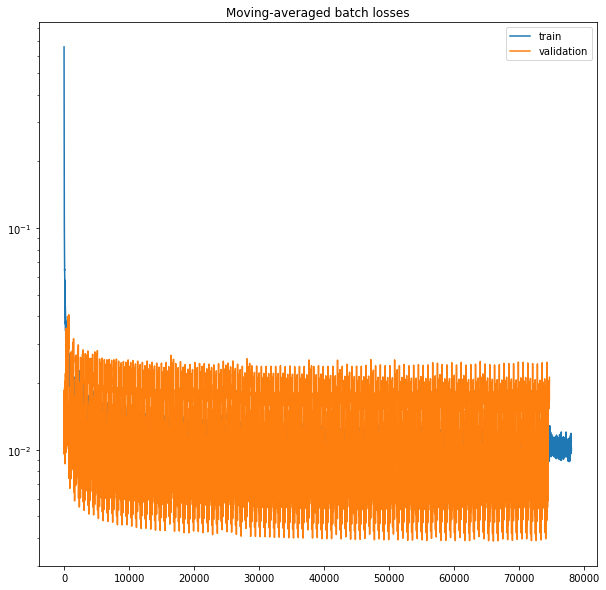

In [26]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [27]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

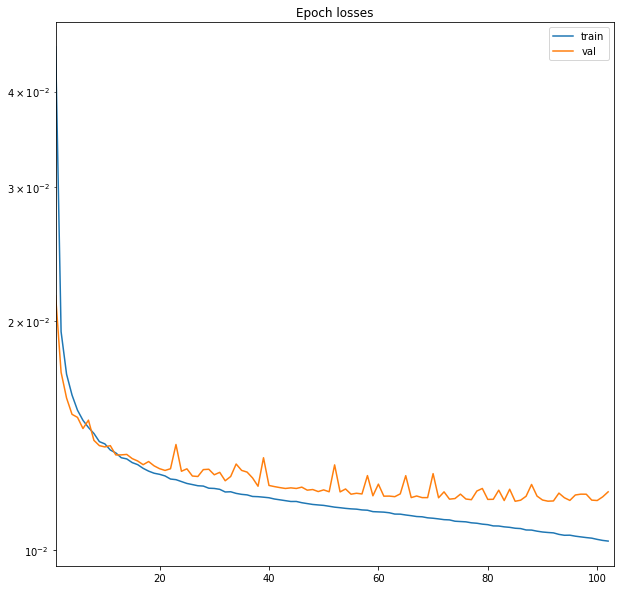

In [28]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Results

In [29]:
import pandas as pd

In [30]:
from visualization_utils import make_df

In [31]:
df = make_df(results, model_name='basic')
df

,accuracy,precision,recall,f1,pr_auc,iou,stack,model
0,0.996681,0.977226,0.976779,0.977002,0.998276,0.955039,carb96558,basic
1,0.988451,0.921849,0.985321,0.952529,0.993558,0.909360,carb71,basic
2,0.979885,0.966416,0.849906,0.904424,0.981483,0.825524,carbRNF,basic
3,0.991886,0.997872,0.902107,0.947576,0.998111,0.900375,SPE_carb10_58_box3,basic
4,0.992222,0.983918,0.882005,0.930178,0.988638,0.869471,SoilAh-1,basic
5,0.994812,0.965481,0.974704,0.970070,0.997281,0.941880,SoilB-2,basic
6,0.988795,0.997422,0.920497,0.957417,0.998092,0.918312,TeTree_subset1,basic
7,0.992729,0.997374,0.938797,0.967199,0.998796,0.936482,TiTree_subset2,basic
8,0.993019,0.971711,0.974258,0.972983,0.997680,0.947388,Urna_22,basic
9,0.990649,0.971826,0.973093,0.972459,0.997745,0.946395,Urna_30,basic


In [32]:
print('Mean   IOU: {:.5}'.format(df['iou'].mean()))
print('Std    IOU: {:.5}'.format(df['iou'].std()))
print('Min    IOU: {:.5}'.format(df['iou'].min()))
print('Median IOU: {:.5}'.format(df['iou'].median()))

Mean   IOU: 0.91437
Std    IOU: 0.038993
Min    IOU: 0.82552
Median IOU: 0.91831
